# Test PySwarms

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Define a "non-differentiable" black-box objective
def true_objective(mu):
    # Here we simulate Choquet-like behavior: non-smooth with some noise
    mu = np.array(mu)
    score = -np.sum(np.sort(mu)**2) + 0.1 * np.sin(10 * mu[0])  # mock complexity
    return score

# Step 2: Collect data (random μ values and objective scores)
np.random.seed(42)
torch.manual_seed(42)

mu_dim = 5       # Let's say μ has 5 components
n_samples = 300

mu_samples = np.random.rand(n_samples, mu_dim)
objective_values = np.array([true_objective(mu) for mu in mu_samples])

# Step 3: Convert to PyTorch tensors
X = torch.tensor(mu_samples, dtype=torch.float32)
y = torch.tensor(objective_values, dtype=torch.float32).unsqueeze(1)

# Step 4: Define a simple neural network (surrogate model)
class SurrogateModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

model = SurrogateModel(mu_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Step 5: Train the model
epochs = 500
for epoch in range(epochs):
    model.train()
    pred = model(X)
    loss = criterion(pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Step 6: Use the trained model to optimize μ (with gradient)
mu = torch.nn.Parameter(torch.rand(mu_dim), requires_grad=True)
opt_mu = optim.Adam([mu], lr=0.01)

for step in range(200):
    opt_mu.zero_grad()
    surrogate_score = model(mu)
    loss = -surrogate_score  # we want to maximize the score
    loss.backward()
    opt_mu.step()
    if step % 40 == 0:
        print(f"Step {step}, Predicted J(mu): {surrogate_score.item():.4f}")

# Final optimized μ
print("\nOptimized μ:", mu.detach().numpy())
print("True objective score of optimized μ:", true_objective(mu.detach().numpy()))


Epoch 0, Loss: 3.1663
Epoch 100, Loss: 0.1468
Epoch 200, Loss: 0.0302
Epoch 300, Loss: 0.0148
Epoch 400, Loss: 0.0093
Step 0, Predicted J(mu): -1.2235
Step 40, Predicted J(mu): -0.3017
Step 80, Predicted J(mu): -0.0801
Step 120, Predicted J(mu): -0.0142
Step 160, Predicted J(mu): 0.0004

Optimized μ: [-0.5208186  -0.2479685  -0.05384332 -0.20990582 -0.00660946]
True objective score of optimized μ: -0.29178464


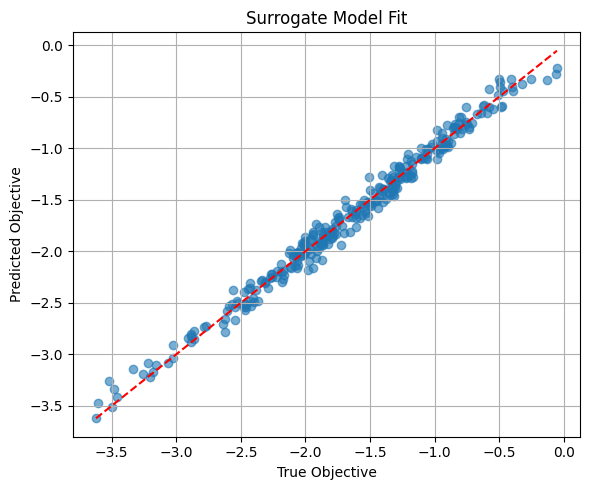

In [2]:
# Step 7: Evaluate model quality (true vs predicted)
model.eval()
with torch.no_grad():
    pred_vals = model(X).squeeze().numpy()

plt.figure(figsize=(6, 5))
plt.scatter(objective_values, pred_vals, alpha=0.6)
plt.plot([min(objective_values), max(objective_values)],
         [min(objective_values), max(objective_values)], 'r--')
plt.xlabel("True Objective")
plt.ylabel("Predicted Objective")
plt.title("Surrogate Model Fit")
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
# Import modules
import numpy as np

# Import PySwarms
import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx

%load_ext autoreload
%autoreload 2


In [5]:
# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

# Call instance of PSO
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=2, options=options)

# Perform optimization
cost, pos = optimizer.optimize(fx.sphere, iters=1000)

2025-04-30 12:05:32,875 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=7.05e-46
2025-04-30 12:05:33,287 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7.053685668730344e-46, best pos: [-9.72515249e-24  2.47141655e-23]


In [6]:
# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9, 'k': 2, 'p': 2}

# Call instance of PSO
optimizer = ps.single.LocalBestPSO(n_particles=10, dimensions=2, options=options)

# Perform optimization
cost, pos = optimizer.optimize(fx.sphere, iters=1000)

2025-04-30 12:06:25,685 - pyswarms.single.local_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 2, 'p': 2}
pyswarms.single.local_best: 100%|██████████|1000/1000, best_cost=2.77e-44
2025-04-30 12:06:26,099 - pyswarms.single.local_best - INFO - Optimization finished | best cost: 2.7679556107956107e-44, best pos: [-7.52724665e-23  1.48369848e-22]


In [7]:
import numpy as np

# create a parameterized version of the classic Rosenbrock unconstrained optimzation function
def rosenbrock_with_args(x, a, b, c=0):
    f = (a - x[:, 0]) ** 2 + b * (x[:, 1] - x[:, 0] ** 2) ** 2 + c
    return f

In [9]:
rosenbrock_with_args(a=1, b=100, c=0, x=np.array([[1, 1], [2, 2]]))

array([  0, 401])

In [12]:
# Load libraries
from palmerpenguins import load_penguins
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import time
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
sns.set_theme(style="whitegrid")

In [13]:
# Import written libraries
import src.utils as ut
import src.fuzz as fz
import src.classif as cl

In [14]:
iris = load_iris(as_frame=True)  # returns a dict-like object
df = iris.frame  # get as pandas DataFrame

X = df.drop(columns='target')  # features
y = df['target']  # target

# Turn into array
X = np.array(X)
y = np.array(y)

# Hyperparameters
dim = X.shape[1]  # number of features
nb_classes = len(np.unique(y))  # number of classes

# Normalize data
data_norm = fz.batch_norm(X)
data_labels = ut.convert_to_float_lst(y)
print(f"Normalized data: {data_norm.shape[0]} samples in {data_norm.shape[1]}D space.")

Normalized data: 150 samples in 4D space.


In [ ]:
# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9, 'k': 2, 'p': 2}

# Call instance of PSO
optimizer = ps.single.LocalBestPSO(n_particles=10, dimensions=2, options=options)

# Perform optimization
cost, pos = optimizer.optimize(fz.generate_capacity, iters=1000)

2025-04-30 14:14:28,391 - pyswarms.single.local_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 2, 'p': 2}
pyswarms.single.local_best:   0%|          |0/1000


TypeError: 'list' object is not callable